In [1]:
import numpy as np
import os
from configparser import ConfigParser
from visualization import load_depth, draw3dbboxes_pillow, camera_to_string
import visualization
from PIL import Image
import pickle
import json
import time
from shutil import copyfile
import moviepy
from moviepy.editor import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from joblib import Parallel, delayed

In [10]:
ini_file = "gta-postprocessing.ini"
visualization.multi_page = False
visualization.ini_file = ini_file
visualization.use_cache = False

conn = visualization.get_connection()
cur = conn.cursor()

CONFIG = ConfigParser()
CONFIG.read(ini_file)
in_directory = r'D:\output-datasets\onroad-4'
out_directory = r'D:\showing-videos\onroad-4'

directory_per_camera = False

In [11]:
#run_id = 19
#run_id = 3677
run_id = 4180

cur.execute("""SELECT imagepath, \
      ARRAY[st_x(camera_relative_rotation), st_y(camera_relative_rotation), st_z(camera_relative_rotation)] as camera_relative_rotation,
      ARRAY[st_x(camera_relative_position), st_y(camera_relative_position), st_z(camera_relative_position)] as camera_relative_position 
      FROM snapshots \
      WHERE run_id = {} AND camera_fov != 0 \
      ORDER BY timestamp ASC \
    """.format(run_id))
# camera fov is sanity check for malformed images
results = []
for row in cur:
    res = dict(row)
    #res['camera_relative_rotation'] = np.array(res['camera_relative_rotation'])
    results.append(res)

print('There are {} snapshots'.format(len(results)))

There are 2076 snapshots


In [12]:
# because sometimes I use two cameras heading same direction, pair (position, rotation) is unique identifier
cur.execute("""SELECT DISTINCT \
      ARRAY[st_x(camera_relative_rotation), st_y(camera_relative_rotation), st_z(camera_relative_rotation)] as camera_relative_rotation, 
      ARRAY[st_x(camera_relative_position), st_y(camera_relative_position), st_z(camera_relative_position)] as camera_relative_position 
      FROM snapshots \
      WHERE run_id = {} AND camera_fov != 0 \
      ORDER BY camera_relative_position, camera_relative_rotation ASC \
    """.format(run_id))
# camera fov is sanity check for malformed images
print('there are following relative camera rotations')
cam_configurations = []
camera_names = {}
for i, row in enumerate(cur):
    print(row['camera_relative_rotation'])
    print(row['camera_relative_position'])
    cam_configurations.append((row['camera_relative_rotation'], row['camera_relative_position']))
    camera_name = camera_to_string(row)
    camera_names[camera_name] = str(i)


there are following relative camera rotations
[0.0, 0.0, 90.0]
[-0.800000011920929, 0.800000011920929, 0.400000005960464]
[0.0, 0.0, 180.0]
[0.0, -2.29999995231628, 0.300000011920929]
[0.0, 0.0, 0.0]
[0.0, 2.0, 0.300000011920929]
[0.0, 0.0, 270.0]
[0.800000011920929, 0.800000011920929, 0.400000005960464]


In [13]:
def split_results_by_relative_cam_configurations(results):
    res_groups = {}
    for cam_conf in cam_configurations:
        res_groups[str(cam_conf)] = [i for i in results if (i['camera_relative_rotation'], i['camera_relative_position']) == cam_conf]
    return res_groups

def result_group_to_video(results, suffix):
    if directory_per_camera:
        img_sequence = [os.path.join(in_directory, camera_names[camera_to_string(i)], i['imagepath']+suffix) for i in results]
    else:
        img_sequence = [os.path.join(in_directory, i['imagepath']+suffix) for i in results]
    
    img_sequence = [i for i in img_sequence if os.path.exists(i)]
    clip = ImageSequenceClip(img_sequence, fps=10)
    return clip

def process_depth_image(image):
    image = np.array(image.convert('RGB')) / np.iinfo(np.uint16).max
    return image
    
def result_depth_group_to_video(results, suffix):
    img_sequence = [os.path.join(in_directory, i['imagepath']+suffix) for i in results]
    img_sequence = [Image.open(i) for i in img_sequence]
    workers = 8
    img_sequence = Parallel(n_jobs=workers, backend='threading')(delayed(process_depth_image)(i) for i in img_sequence)
    clip = ImageSequenceClip(img_sequence, fps=10)
    # moviepy does not work with grayscale images yet
    #clip = clip.fl_image(process_depth_image)
    return clip

def process_stencil_image(colors, image):
    image = np.array(image) % 8
    image = colors[image]
    return image
    
def result_stencil_group_to_video(results, suffix):
    colors = (plt.cm.viridis(np.linspace(0, 1, 8))[:, :3] * np.iinfo(np.uint8).max).astype(np.uint8)
    img_sequence = [os.path.join(in_directory, i['imagepath']+suffix) for i in results]
    img_sequence = [Image.open(i) for i in img_sequence]  # IO operation, no need to perallelize
    # from 60 to 16 seconds sppedup, nice, all cores at full load
    workers = 8
    img_sequence = Parallel(n_jobs=workers, backend='threading')(delayed(process_stencil_image)(colors, i) for i in img_sequence)
    clip = ImageSequenceClip(img_sequence, fps=10)
    # moviepy does not work with grayscale images yet
    #clip = clip.fl_image(process_stencil_image)
    return clip


### preparing data

In [14]:
result_groups = split_results_by_relative_cam_configurations(results)


In [15]:
for cam_conf, res in result_groups.items():
    print(cam_conf)
    print(len(res))

([0.0, 0.0, 90.0], [-0.800000011920929, 0.800000011920929, 0.400000005960464])
519
([0.0, 0.0, 180.0], [0.0, -2.29999995231628, 0.300000011920929])
523
([0.0, 0.0, 0.0], [0.0, 2.0, 0.300000011920929])
521
([0.0, 0.0, 270.0], [0.800000011920929, 0.800000011920929, 0.400000005960464])
513


### dumping data to videos

In [16]:
# splitting individual videos into functions, so they are not buffered at once into the memory
def make_rgb_video(cam_conf, res):
    clip = result_group_to_video(res, '.jpg')
    video_name = os.path.join(out_directory, "camera-{}.mp4".format(cam_conf))
    clip.write_videofile(video_name, audio=False, codec='mpeg4', threads=8)

def make_depth_video(cam_conf, res):
    depth_clip = result_depth_group_to_video(res, '-depth.png')
    video_name = os.path.join(out_directory, "camera-{}-depth.mp4".format(cam_conf))
    depth_clip.write_videofile(video_name, audio=False, codec='mpeg4')

def make_stencil_video(cam_conf, res):
    stencil_clip = result_stencil_group_to_video(res, '-stencil.png')
    video_name = os.path.join(out_directory, "camera-{}-stencil.mp4".format(cam_conf))
    stencil_clip.write_videofile(video_name, audio=False, codec='mpeg4')

if not os.path.exists(out_directory):
    os.makedirs(out_directory)

for cam_conf, res in result_groups.items():
    make_rgb_video(cam_conf, res)
    # beware, following two lines eat shitload of RAM
    #make_depth_video(cam_conf, res)
    #make_stencil_video(cam_conf, res)
    
#time to load images 23.967074155807495
#time to transform images 51.597939252853394
#time to prepare sequence clip 0.0010004043579101562

#time to load images 0.28050708770751953
#time to transform images 63.57286500930786
#time to prepare sequence clip 0.0005006790161132812

[MoviePy] >>>> Building video D:\showing-videos\onroad-4\camera-([0.0, 0.0, 90.0], [-0.800000011920929, 0.800000011920929, 0.400000005960464]).mp4
[MoviePy] Writing video D:\showing-videos\onroad-4\camera-([0.0, 0.0, 90.0], [-0.800000011920929, 0.800000011920929, 0.400000005960464]).mp4


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:16<00:00, 25.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: D:\showing-videos\onroad-4\camera-([0.0, 0.0, 90.0], [-0.800000011920929, 0.800000011920929, 0.400000005960464]).mp4 

[MoviePy] >>>> Building video D:\showing-videos\onroad-4\camera-([0.0, 0.0, 180.0], [0.0, -2.29999995231628, 0.300000011920929]).mp4
[MoviePy] Writing video D:\showing-videos\onroad-4\camera-([0.0, 0.0, 180.0], [0.0, -2.29999995231628, 0.300000011920929]).mp4


100%|████████████████████████████████████████████████████████████████████████████████| 426/426 [00:16<00:00, 25.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: D:\showing-videos\onroad-4\camera-([0.0, 0.0, 180.0], [0.0, -2.29999995231628, 0.300000011920929]).mp4 

[MoviePy] >>>> Building video D:\showing-videos\onroad-4\camera-([0.0, 0.0, 0.0], [0.0, 2.0, 0.300000011920929]).mp4
[MoviePy] Writing video D:\showing-videos\onroad-4\camera-([0.0, 0.0, 0.0], [0.0, 2.0, 0.300000011920929]).mp4


100%|████████████████████████████████████████████████████████████████████████████████| 427/427 [00:17<00:00, 24.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: D:\showing-videos\onroad-4\camera-([0.0, 0.0, 0.0], [0.0, 2.0, 0.300000011920929]).mp4 

[MoviePy] >>>> Building video D:\showing-videos\onroad-4\camera-([0.0, 0.0, 270.0], [0.800000011920929, 0.800000011920929, 0.400000005960464]).mp4
[MoviePy] Writing video D:\showing-videos\onroad-4\camera-([0.0, 0.0, 270.0], [0.800000011920929, 0.800000011920929, 0.400000005960464]).mp4


100%|████████████████████████████████████████████████████████████████████████████████| 413/413 [00:16<00:00, 25.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: D:\showing-videos\onroad-4\camera-([0.0, 0.0, 270.0], [0.800000011920929, 0.800000011920929, 0.400000005960464]).mp4 



In [9]:
# copied from ImageSequenceClip constructor
def find_image_index(clip, t):
    return max([i for i in range(len(clip.sequence))
                      if clip.images_starts[i]<=t])

def get_base_name(name):
    return os.path.basename(os.path.splitext(name)[0])

def draw_bboxes(rgb, path, directory):
    base_name = get_base_name(path)
    depth_file = os.path.join(directory, '{}-depth.png'.format(base_name))
    stencil_file = os.path.join(directory, '{}-stencil.png'.format(base_name))
    json_file = os.path.join(directory, '{}.json'.format(base_name))
    depth = np.array(Image.open(depth_file))
    depth = depth / np.iinfo(np.uint16).max  # normalizing into NDC
    stencil = np.array(Image.open(stencil_file))
    with open(json_file, mode='r') as f:
        data = json.load(f)
    im = draw3dbboxes_pillow(rgb, depth, stencil, data)
    return np.array(im)
    
def result_group_to_video_with_bboxes(results, suffix):
    img_sequence = [os.path.join(in_directory, i['imagepath']+suffix) for i in results]
    img_sequence = [i for i in img_sequence if os.path.exists(i)]
    clip = ImageSequenceClip(img_sequence, fps=10)
    #clip = clip.fl_image(draw_bboxes)
    clip = clip.fl(lambda gf, t: draw_bboxes(gf(t), clip.sequence[find_image_index(clip, t)], in_directory), []) # instead of fl_image, here I use fl, so I access both image and its name

    return clip

def make_rgb_video_with_bboxes(cam_conf, res):
    clip = result_group_to_video_with_bboxes(res, '.jpg')
    video_name = os.path.join(out_directory, "camera-{}-annotated.mp4".format(cam_conf))
    clip.write_videofile(video_name, audio=False, codec='mpeg4', threads=8)


In [9]:
for cam_conf, res in result_groups.items():
    if '[0.0, 0.0, 0.0]' not in cam_conf:
        continue
    make_rgb_video_with_bboxes(cam_conf, res)
    break


[MoviePy] >>>> Building video D:\showing-videos\onroad-1\camera-([0.0, 0.0, 0.0], [0.0, 2.0, 0.300000011920929])-annotated.mp4
[MoviePy] Writing video D:\showing-videos\onroad-1\camera-([0.0, 0.0, 0.0], [0.0, 2.0, 0.300000011920929])-annotated.mp4


100%|██████████████████████████████████████████████████████████████████████████████| 1292/1292 [17:31<00:00,  1.96s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: D:\showing-videos\onroad-1\camera-([0.0, 0.0, 0.0], [0.0, 2.0, 0.300000011920929])-annotated.mp4 



In [ ]:
name = os.path.join(in_directory, result_groups['[0, 0, 0]'][0]['imagepath']+'-depth.png')
depth_arr = np.array(Image.open(name).convert('RGB'))
depth_arr_2 = np.array(Image.open(name).convert('L').convert('RGB'))
depth_arr_3 = np.array(Image.open(name).convert('L'))
arr_single = np.array(Image.open(name))

In [ ]:
depth_arr.max()

In [ ]:
arr_single.max()

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.imshow(arr_single, cmap='gray')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(depth_arr_3, cmap='gray')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(depth_arr_2)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(depth_arr)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.hist(arr_single.flatten())
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.hist(depth_arr.flatten())
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.hist(depth_arr_2.flatten())
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.hist(depth_arr_3.flatten())
plt.show()

In [37]:
arr_single_cropped = arr_single[arr_single < 256]
fig = plt.figure(figsize=(10, 10))
plt.hist(arr_single_cropped.flatten())
plt.show()

NameError: name 'arr_single' is not defined

In [116]:
im_stencil = os.path.join(in_directory, next(iter(result_groups.values()))[0]['imagepath']+'-stencil.png')
im_stencil = np.array(Image.open(im_stencil))
im_stencil = im_stencil % 8
colors = (plt.cm.viridis(np.linspace(0, 1, 8))[:, :3] * np.iinfo(np.uint8).max).astype(np.uint8)
im_stencil = colors[im_stencil]

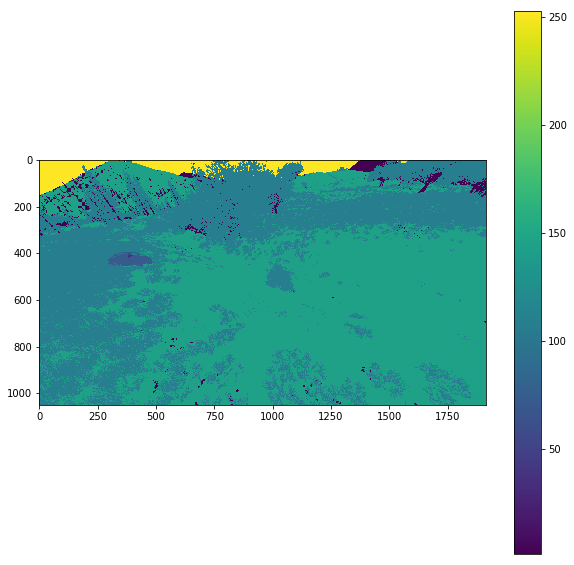

In [117]:
fig = plt.figure(figsize=(10, 10))
ii = plt.imshow(im_stencil)
plt.colorbar(ii)
plt.show()

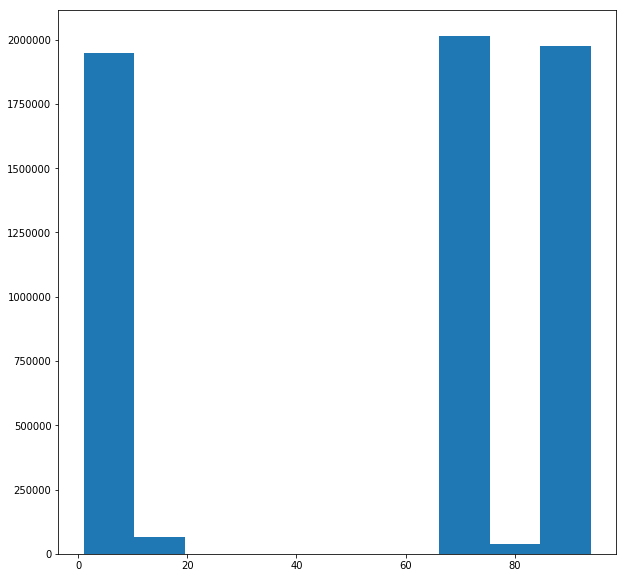

In [56]:
fig = plt.figure(figsize=(10, 10))
plt.hist(im_stencil.flatten())
plt.show()